## 데이터 모으기
### Selenium

In [33]:
# import 해줄 것들
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
from selenium import webdriver
import sys
from tqdm.notebook import tqdm
from selenium.webdriver.common.keys import Keys

In [53]:
# 사이트 접속
url = input('네이버 스마트 스토어 URL 입력:')
driver = webdriver.Chrome('c:/py_data/chromedriver.exe')
driver.get(url)
time.sleep(2)

html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
review_area = soup.find('table',class_='list_netizen').find_all('tr')
review_num = int(soup.find('strong', class_='c_88 fs_11').text)

네이버 스마트 스토어 URL 입력:https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=200052&target=after


In [54]:
review_lst = []
point_lst = []
id_lst = []

for page in tqdm(range(review_num//(len(review_area)-1)+1)):
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    review_area1 = soup.find('table',class_='list_netizen').find_all('tr') # =11
    
    for i in review_area1[1:]:
        review = re.sub("[^가-힣 ]","",i.text).replace('도라에몽 스탠바이미 별점  총 점 중','',).replace('신고','')
        point = int(i.find('em').text)
        id = i.find('td').text
        
        review_lst.append(review)
        point_lst.append(point)
        id_lst.append(id)
        
    try:
        driver.find_element_by_css_selector('#old_content > div.paging > div > a.pg_next').click()
        time.sleep(1)
    except:
        pass
    
        

In [55]:
df = pd.DataFrame({'ID':id_lst,'평점':point_lst,'리뷰':review_lst})
df

,ID,평점,리뷰
0,17536955,5,어린이용 테넷인줄 생각보다 스토리가 던져둔 떡밥회수를 잘합니다 근데 감동 포인트가 ...
1,17536336,10,진구의 현재와 과거의 접점을 정확하게 이어주면서 재미를 주고 할머니를 등장시킨것도 ...
2,17535872,10,내가 어릴 적 좋아했던 도라에몽어른이 되어서도 감동있고 재밌네요
3,17535146,7,성장은 언제나 아픈 법
4,17534975,10,너무너무 재밌고 감동이네요 저도 어린시절에 뛰어놀던 그시절로 돌아 가보고싶어요 엄마...
...,...,...,...
203,17517631,10,사랑합니다 노진구 보고 싶어요
204,17517594,10,개인적으로 가장 좋아하는 캐릭터 한국개봉 첫날 첫회 상영 보았습니다 스토리 영상미...
205,17517523,10,인생작 그래픽좋고 스토리좋아요
206,17517505,10,개봉하기전에 감상평작성합니다 재미써요


In [56]:
df.to_csv('c:/py_data/도라에몽 영화 평점,리뷰 크롤링.csv', encoding='cp949')

### request

In [58]:
import requests
from bs4 import BeautifulSoup  
import pandas as pd
import re
url = input('영화 url 입력:')
page_url = '&page='

html = requests.get(url + page_url + '1')
soup = BeautifulSoup(html.text,'html.parser')
title = re.sub('[^가-힣a-zA-Z ]','',soup.find('h5').text)
tbody_area = soup.find('tbody')
id_tag = tbody_area.find_all('td',class_='ac num')
max_range = int(soup.find('strong',class_='c_88 fs_11').text.replace(',',''))
# 121 -> 12
id_lst=[]
point_lst=[]
review_lst=[]
for page in range(1,(max_range//len(id_tag))+2):
    html = requests.get(url + page_url + str(page))
    soup = BeautifulSoup(html.text,'html.parser')
    title = re.sub('[^가-힣a-zA-Z ]','',soup.find('h5').text)
        
    tbody_area = soup.find('tbody')
    
    id_tag = tbody_area.find_all('td',class_='ac num')
    point_tag = tbody_area.find_all('em')
    review_tag = tbody_area.find_all('td',class_='title')
    
    for i in range(len(id_tag)):
        id_ = id_tag[i].text
        point = int(point_tag[i].text)
        review = re.sub('[^가-힣a-zA-Z ]','',review_tag[i].text.split('\n\n')[2].replace('신고',''))
        
        id_lst.append(id_)
        point_lst.append(point)
        review_lst.append(review)
df = pd.DataFrame({'id':id_lst,'point':point_lst,'review':review_lst})
df.to_csv('c:/py_data/영화_'+title+'_리뷰.csv',encoding='cp949')

영화 url 입력:https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=201863&target=after


## 연관 분석 (장바구니 분석)

### support(지지도)

전체 거래에서 특정 물품 A와 B가 동시에 거래되는 비중

해당 규칙이 얼마나 의미있는지 보여줌.

 

지지도 = P(A∩B)

:A와 B가 동시에 일어난 횟수 / 전체 거래 횟수   


 

 
   
      
      
### confiddence(신뢰도)

A를 포함하는 거래 중 A와 B가 동시에 거래되는 비중

 

신뢰도 = P(A∩B) / P(A)

:A와 B가 동시에 일어난 횟수 / A가 일어난 횟수   


 

    
    

### lift(향상도)

A라는 상품에서 신뢰도가 동일한 상품 B와 C가 존재할 때, 어떤 상품을 더 추천해야 좋을지 판단.

A와 B가 동시에 거래된 비중을 A와 B가 서로 독립된 사건일 때 동시에 거래된 비중으로 나눈 값

 

향상도 = P(A∩B) / P(A)*P(B) = P (B|A) / P (B)

: A와 B가 동시에 일어난 횟수 / A, B가 독립된 사건일 때 A,B가 동시에 일어날 확률

In [60]:
# !pip install apyori

In [61]:
dataset = [['아메리카노','카페라떼'],
           ['카페라떼','아메리카노','카푸치노'],
           ['바닐라라떼','아메리카노'],
           ['녹차라떼','카페라떼','아메리카노'],
           ['카페모카','아메리카노'],
           ['아메리카노','카페라떼'],
           ['초콜릿','아메리카노'],
           ['아메리카노'],
           ['카페모카','카페라떼'],
           ['아메리카노','카푸치노']]

In [62]:
from apyori import apriori
results = list(apriori(dataset,
             min_support=0.2,    # 지지도
             min_confidence=0.1, # 신뢰도
             min_lift=1.0,       # 향상도
             max_length=2))      # 크기가 2인 규칙
results

[RelationRecord(items=frozenset({'아메리카노'}), support=0.9, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'아메리카노'}), confidence=0.9, lift=1.0)]),
 RelationRecord(items=frozenset({'카페라떼'}), support=0.5, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'카페라떼'}), confidence=0.5, lift=1.0)]),
 RelationRecord(items=frozenset({'카페모카'}), support=0.2, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'카페모카'}), confidence=0.2, lift=1.0)]),
 RelationRecord(items=frozenset({'카푸치노'}), support=0.2, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'카푸치노'}), confidence=0.2, lift=1.0)]),
 RelationRecord(items=frozenset({'카페라떼', '아메리카노'}), support=0.4, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'카페라떼', '아메리카노'}), confidence=0.4, lift=1.0)]),
 RelationRecord(items=frozenset({'카푸치노', '아메리카노'}), support=0.2, ordered_statistics=[OrderedSta

In [65]:
results[4]

RelationRecord(items=frozenset({'카페라떼', '아메리카노'}), support=0.4, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'카페라떼', '아메리카노'}), confidence=0.4, lift=1.0)])

In [67]:
import pandas as pd
# 데이터 프레임 형태로 정리합니다.
columns = ['source','target','support']
network_df = pd.DataFrame(columns=columns)
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]   #
        row = [items[0],items[1],result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)
network_df

,source,target,support
0,카페라떼,아메리카노,0.4
1,카푸치노,아메리카노,0.2


In [ ]:
# items = [x for x in result.items]
# = 
# items = []
# 

In [68]:
# 2차원 리스트를 1차원으로 변경
one_dataset = []
for i in dataset:
    one_dataset = one_dataset + i

In [69]:
one_dataset

['아메리카노',
 '카페라떼',
 '카페라떼',
 '아메리카노',
 '카푸치노',
 '바닐라라떼',
 '아메리카노',
 '녹차라떼',
 '카페라떼',
 '아메리카노',
 '카페모카',
 '아메리카노',
 '아메리카노',
 '카페라떼',
 '초콜릿',
 '아메리카노',
 '아메리카노',
 '카페모카',
 '카페라떼',
 '아메리카노',
 '카푸치노']

In [70]:
from collections import Counter
count = Counter(one_dataset)
count

Counter({'아메리카노': 9,
         '카페라떼': 5,
         '카푸치노': 2,
         '바닐라라떼': 1,
         '녹차라떼': 1,
         '카페모카': 2,
         '초콜릿': 1})

In [71]:
node_df = pd.DataFrame(count.items(), columns=['node','nodesize'])
node_df.head(3)

,node,nodesize
0,아메리카노,9
1,카페라떼,5
2,카푸치노,2


In [72]:
import networkx as nx

nx.__version__

'2.5'

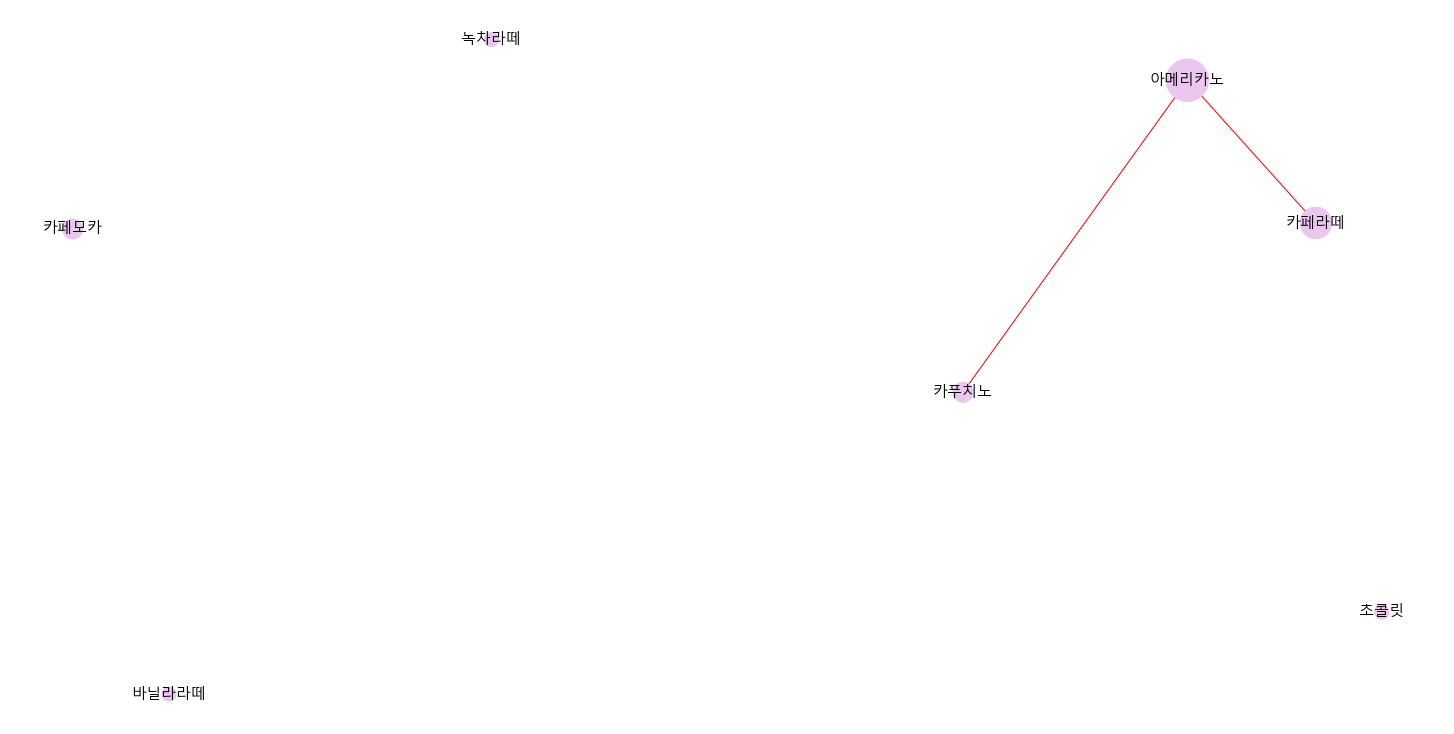

In [78]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.figure(figsize=(20,10)) 

# networkx 그래프 객체를 생성합니다.
G = nx.Graph() 

# node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 
# ‘노드’ 역할을 하는 원을 생성합니다.

for index, row in node_df.iterrows():
    G.add_node(row['node'], nodesize=row['nodesize'])    

# network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘
# 관계’ 역할을 하는 선을 생성합니다.
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    

# 그래프 디자인과 관련된 파라미터를 설정합니다.
# https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html

pos = nx.spring_layout(G, k=0.5, iterations=40)
sizes = [G.nodes[node]['nodesize']*200 for node in G]
nx.draw(G, pos=pos, node_size=sizes,with_labels=False, 
        edge_color='#FF0000',node_color = '#ebc7f0')
 

# 한글폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
fname = fm.FontProperties(fname=font_path).get_name()
nx.draw_networkx_labels(G, pos=pos, font_size=15,font_family=fname) 

# 그래프를 출력합니다.
ax = plt.gca()
plt.show()